In [2]:
import os
os.chdir('/home/wisc/maheswararao/code/stain2stain/stain2stain')

In [13]:
from src.models.class_conditional_flow_matching import ClassConditionalFlowMatchingLitModule
from torchcfm.models.unet import UNetModel

In [30]:
ckpt_path = 'logs/train/runs/2026-01-12_12-43-09/checkpoints/last.ckpt'
data_path = "/data1/shared/data/destain_restain/he_amyloid/test_he/amyloid-plaque/"

In [32]:
# os.listdir(data_path)

In [15]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import hydra
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
from omegaconf import DictConfig, OmegaConf

# read config file
model_config = OmegaConf.load("configs/model/class_conditional_flow_matching.yaml")
flow_matcher = hydra.utils.instantiate(model_config)


In [19]:
model = hydra.utils.instantiate(model_config)
model = model.to(device)
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


/home/wisc/maheswararao/code/stain2stain/stain2stain/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


In [23]:
checkpoint = torch.load(ckpt_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [24]:
# Define image preprocessing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Define reverse transform for visualization
def denormalize(tensor):
    """Convert normalized tensor back to [0, 1] range"""
    return tensor * 0.5 + 0.5

In [33]:
# Load a test image
test_images = sorted(list(Path(data_path).glob('*.png')) + list(Path(data_path).glob('*.jpg')))
print(f"Found {len(test_images)} test images")

# Select one image for testing
if len(test_images) > 0:
    img_path = test_images[0]
    source_img = Image.open(img_path).convert('RGB')
    source_tensor = transform(source_img).unsqueeze(0).to(device)
    
    print(f"Loaded image: {img_path.name}")
    print(f"Image shape: {source_tensor.shape}")
else:
    print("No test images found!")

Found 160 test images
Loaded image: 135040e981d9c0ed_part-A3_hippo-beta-amyloid-plaque_40x_001.png
Image shape: torch.Size([1, 3, 256, 256])


In [34]:
# Define target classes
# 0: HE (Hematoxylin and Eosin)
# 1: IHC (Immunohistochemistry) 
# 2: Grayscale

target_classes = {
    0: "HE",
    1: "IHC", 
    2: "Grayscale"
}

print("Available target classes:")
for idx, name in target_classes.items():
    print(f"  {idx}: {name}")

Available target classes:
  0: HE
  1: IHC
  2: Grayscale


In [35]:
# Generate images for all target classes
with torch.no_grad():
    results = {}
    for target_class, class_name in target_classes.items():
        print(f"Generating {class_name}...")
        generated = model.generate(source_tensor, target_class=target_class, num_steps=100)
        results[class_name] = generated.cpu()
    
print("Generation complete!")

Generating HE...
Generating IHC...
Generating Grayscale...
Generation complete!


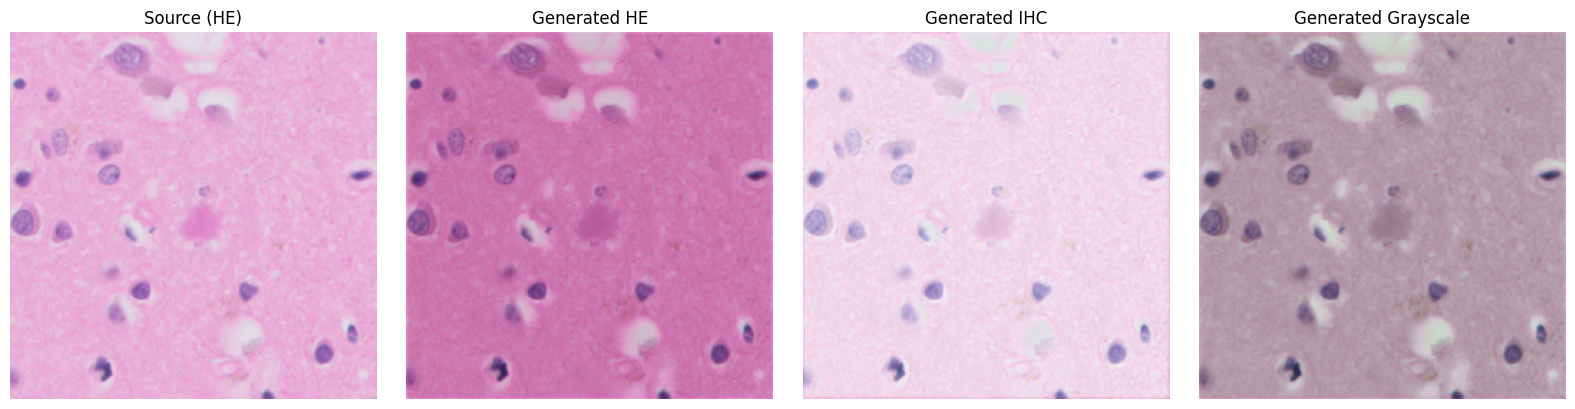

In [36]:
# Visualize results
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Show source image
source_display = denormalize(source_tensor[0]).cpu().permute(1, 2, 0).numpy()
source_display = np.clip(source_display, 0, 1)
axes[0].imshow(source_display)
axes[0].set_title('Source (HE)', fontsize=12)
axes[0].axis('off')

# Show generated images
for idx, (class_name, generated_tensor) in enumerate(results.items(), start=1):
    img_display = denormalize(generated_tensor[0]).permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)
    axes[idx].imshow(img_display)
    axes[idx].set_title(f'Generated {class_name}', fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## Batch Inference on Multiple Images

In [ ]:
# Process multiple images and save results
output_dir = Path("./inference_outputs")
output_dir.mkdir(exist_ok=True)

# Choose target class for batch conversion
target_class = 1  # IHC
target_name = target_classes[target_class]

print(f"Converting all images to {target_name}...")

for img_path in test_images[:10]:  # Process first 10 images
    # Load and preprocess
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Generate
    with torch.no_grad():
        generated = model.generate(img_tensor, target_class=target_class, num_steps=100)
    
    # Save result
    output_img = denormalize(generated[0]).cpu().permute(1, 2, 0).numpy()
    output_img = np.clip(output_img * 255, 0, 255).astype(np.uint8)
    output_path = output_dir / f"{img_path.stem}_to_{target_name}.png"
    Image.fromarray(output_img).save(output_path)
    
    print(f"Saved: {output_path.name}")

print(f"\nAll results saved to: {output_dir}")